# 2D to 3D LSTM

This is the first approach to try to estimate 3D points coordinates from 2D keypoints extracted with Openpose. Here I will build a simple LSTM to perform the task over the Panoptic Studio dataset.

First, let's import all the necessary libraries.

In [1]:
# Pytorch utilities
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
# Plotting utilities
import matplotlib
%matplotlib widget
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from timeit import default_timer as timer
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
import matplotlib.animation as animation

# Directory and file utilities
from os import listdir
from os.path import isfile, isdir, join
import json

## Data acquisition
Now I will define some functions in order to parse and organise the data, and later convert it to pytorch tensors.

The data is structured as follows: in the dataset directory there are several folders, each folder corresponds to a recording; each of these folders contains a folder with the audio, folders with face, hands and body keypoints estimations for each frame, and a folder with the video recorded from different views.

In this first approach I will be using the keypoints estimations. Every keypoint folder (face, hands or body) is organized the same way: it contains a json per frame of the video, which includes the 3D keypoints estimation.

The function `get_keypoints` will go through each folder in the dataset directory and retrieve the face keypoints, the hands keypoints and the body keypoints. It will separate them into input (2D coordinates per joint per frame) and grountruth (third coordinate to estimate for each input 2D keypoint). 
The input will be of shape $([n videos, seq len, input size])$, where *seq_len* = number of frames, and *input_size* = face + hands + body keypoints, that is (70+(21+21)+26)x2 -multiplied by 2 because there are x and y coordinates-. The groundtruth (label) data will be of the same shape, except that the last dimension size will not be multiplied by 2 (there's only one coordinate to estimate).  

In [2]:
def get_keypoints(data_path):
    dataset = []
    groundtruth = []
    # Look over just the folders inside the directory
    just_folders = filter(lambda x: isdir(join(data_path, x)), listdir(data_path))
    for p in list(map(lambda x: join(data_path, x), just_folders)): 
        # Gets 2 list of n_frames lists, one for the 2D coordinates and one for the third coordinate.
        # Each list of the n_frames lists contains, either the (x and y) or the z of each keypoint for the face(first line), hands(second), body(third).
        # e.g. the first line will result in [[x1,y1,x2,y2...x70,y70]sub1...[x1,y1...x70,y70]subN], [[z1,z2...z70]sub1...[z1..z70]subN]
        # Actually, as there will be two of each list above because there are two people en each video.
        face_2d, face_3d = get_face(p)
        
        # Concatenates the coordinates for the face, hands and body on the last dimension, for each person.
        vid_input_p1, vid_input_p2 = face_2d
        vid_labels_p1, vid_labels_p2 = face_3d
        
        dataset.append(vid_input_p1)
        dataset.append(vid_input_p2)
        groundtruth.append(vid_labels_p1)
        groundtruth.append(vid_labels_p2)
        print(f'Completed folder {p}')
    return dataset, groundtruth

The following functions are in charge of retrieving the keypoints from each json. The json face json has a key *people* with a list of person objects. Each person object has *id* field and *landmarks* field, the latter containing a list of 3D coordinates for each keypoint.

In [3]:
def get_face(path):
    face_2D_seq = ([], [])
    face_3D_seq = ([], [])
    # List only the files (json), for there might be folders containing invalid frames.
    paths = map(lambda x: join(path, 'hdFace3d', x), sorted(listdir(join(path, 'hdFace3d'))))
    files = list(filter(lambda x: isfile(x), paths))
    for f in files: # The first frame of face keypoints estimation it's blank
        with open(f, 'r') as j:
            json_array = json.load(j)
            i = 0
            for person in json_array['people']:
                if person['id'] != -1: # If the id is -1, it means there's no person
                    x = person['face70']['landmarks'][::3]
                    y = person['face70']['landmarks'][1::3]
                    two_coord = [l[item] for item in range(len(x)) for l in [x,y]]
                    third_coord = person['face70']['landmarks'][2::3]
                    face_2D_seq[person['id']].append(two_coord)
                    face_3D_seq[person['id']].append(third_coord)
                    i+=1
                    pid = person['id']
            if i<2: # In case there was only one person detected on a frame
                face_2D_seq[1-pid].append(face_2D_seq[1-pid][-1])
                face_3D_seq[1-pid].append(face_3D_seq[1-pid][-1])
    print('Face completed.')
    # Each return var being a tuple with the list of n_frames list of coordinates for each person
    return face_2D_seq, face_3D_seq

In [4]:
data_path = '../../../data/DB keypoints'
dataset, groundtruth = get_keypoints(data_path)

Face completed.
Completed folder ../../../data/DB keypoints/190419_asl2
Face completed.
Completed folder ../../../data/DB keypoints/190419_asl4
Face completed.
Completed folder ../../../data/DB keypoints/190419_asl5
Face completed.
Completed folder ../../../data/DB keypoints/190425_asl1
Face completed.
Completed folder ../../../data/DB keypoints/190425_asl2
Face completed.
Completed folder ../../../data/DB keypoints/190425_asl3
Face completed.
Completed folder ../../../data/DB keypoints/190425_asl5
Face completed.
Completed folder ../../../data/DB keypoints/190425_asl7
Face completed.
Completed folder ../../../data/DB keypoints/190425_asl9
Face completed.
Completed folder ../../../data/DB keypoints/190425_asl91
Face completed.
Completed folder ../../../data/DB keypoints/190611_asl1
Face completed.
Completed folder ../../../data/DB keypoints/190611_asl2
Face completed.
Completed folder ../../../data/DB keypoints/190611_asl3
Face completed.
Completed folder ../../../data/DB keypoints/190

## Dataset structuring
Now let's convert the lists obtained to Pytorch tensors and organise them in train, validation and test datasets. 
First, I will define a padding function in order to make all the sequences of video frames the same length, so I can train the LSTM in batches. 

In [5]:
def padding_seq(dataset):
    max_seq = max([len(x) for x in dataset])
    seq_lengths = []
    for seq in dataset:
        seq_lengths.append(len(seq))
        for i in range(max_seq-len(seq)):
            seq.append([np.nan for j in range(len(seq[0]))])
        
    return max_seq, seq_lengths

max_seq, seq_lengths = padding_seq(dataset)
_, _ = padding_seq(groundtruth)

In [6]:
# From python lists to numpy ndarray.
dataset = np.asarray(dataset)
groundtruth = np.asarray(groundtruth)
lengths = np.asarray(seq_lengths)
print(dataset.shape, groundtruth.shape, lengths.shape)

(36, 8752, 140) (36, 8752, 70) (36,)


In [7]:
np.save('../../pickles/face_data.npy', dataset)
np.save('../../pickles/face_ground.npy', groundtruth)

In [8]:
np.save('../../pickles/face_lengths.npy', lengths)

In [9]:
dataset = np.load('../../pickles/face_data.npy', allow_pickle=True)
groundtruth = np.load('../../pickles/face_ground.npy', allow_pickle=True)
lengths = np.load('../../pickles/face_lengths.npy', allow_pickle=True)
max_seq = dataset.shape[1]
print(max_seq)

8752


In [7]:
def norm_uniform(tensor, coordinates=1):
    max_value = [np.nanmax(tensor[:, :,i::coordinates]) for i in range(coordinates)]
    min_value = [np.nanmin(tensor[:, :,i::coordinates]) for i in range(coordinates)]
    center = [(max_value[i]+min_value[i])/2 for i in range(coordinates)]
    for j in range(coordinates):
        subtensor = tensor[:, :, j::coordinates]
        subtensor[:] = np.subtract(subtensor, center[j])
        subtensor[:] = np.divide(subtensor, max_value[j]-center[j])

norm_uniform(dataset,2)
norm_uniform(groundtruth)

For each axis I normalize the keypoints using the following formula:

In [8]:
def normalize(tensor, coordinates=1):
    mean_value = [np.nanmean(tensor[:, :,i::coordinates]) for i in range(coordinates)]
    std_value = [np.nanstd(tensor[:, :,i::coordinates]) for i in range(coordinates)]
    for j in range(coordinates):
        subtensor = tensor[:, :, j::coordinates]
        subtensor[:] = np.subtract(subtensor, mean_value[j])
        subtensor[:] = np.divide(subtensor, std_value[j])
  
    return [(mean_value[i], std_value[i]) for i in range(coordinates)]

mom_x, mom_y = normalize(dataset, 2)
print(mom_x, mom_y)
mz, stdz = normalize(groundtruth)[0]

(0.0465801079659608, 0.3924178907275954) (-0.6733822475904984, 0.2866100119648594)


In [45]:
# From python lists to pytorch tensors.
dataset = torch.tensor(np.nan_to_num(dataset), dtype=torch.float32)
groundtruth = torch.tensor(np.nan_to_num(groundtruth), dtype=torch.float32)
lengths = torch.tensor(lengths, dtype=torch.float32)

# Randomly shuffle videos
permutation = torch.randperm(dataset.size()[0])
dataset, groundtruth, lengths = dataset[permutation], groundtruth[permutation], lengths[permutation] 
print(dataset.shape, groundtruth.shape, lengths.shape)

torch.Size([36, 8751, 52]) torch.Size([36, 8751, 26]) torch.Size([36])


In [6]:
l1, l2 = len(dataset), len(groundtruth)
# Split in train, validation and test
training_kp, val_kp, test_kp = dataset[:round(0.55*l1)], dataset[round(0.55*l1):round(0.77*l1)], dataset[round(0.77*l1):]
training_lbl, val_lbl, test_lbl = groundtruth[:round(0.55*l2)], groundtruth[round(0.55*l2):round(0.77*l2)], groundtruth[round(0.77*l2):]
training_lengths, val_lengths, test_lengths = lengths[:round(0.55*l1)], lengths[round(0.55*l1):round(0.77*l1)], lengths[round(0.77*l1):]
print(training_kp.shape, val_kp.shape, test_kp.shape)
print(training_lbl.shape, val_lbl.shape, test_lbl.shape)
print(training_lengths.shape, val_lengths.shape, test_lengths.shape)

torch.Size([20, 8751, 276]) torch.Size([8, 8751, 276]) torch.Size([8, 8751, 276])
torch.Size([20, 8751, 138]) torch.Size([8, 8751, 138]) torch.Size([8, 8751, 138])
torch.Size([20]) torch.Size([8]) torch.Size([8])


Finally we define the batch_size and put the datasets in DataLoaders.

In [7]:
train_data = TensorDataset(training_kp, training_lbl, training_lengths)
val_data = TensorDataset(val_kp, val_lbl, val_lengths)
test_data = TensorDataset(test_kp, test_lbl, test_lengths)

batch_size = 2

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

print(train_loader)

If we have a GPU available we set our device to GPU.

In [12]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


Let's print some examples to see whether it is loaded correctly or not.

In [9]:
dataiter = iter(train_loader)
sample_x, sample_y, sample_len = dataiter.next()

print(sample_x.shape, sample_y.shape, sample_len.shape)

torch.Size([2, 8751, 276]) torch.Size([2, 8751, 138]) torch.Size([2])


## Model building
It is time to build the model for this approach. It will consist on a single/double layer LSTM followed by a Linear layer with output size the number of keypoints we want to estimate. I also define a method to initialize the hidden_state of the cell.

In [10]:
class LSTM_2D3D(nn.Module):
    
    def __init__(self, input_size, output_size, hidden_dim, n_layers, bidirectional, dropout=0.):
        super().__init__()
        # Save the model parameters
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.bi = bidirectional
        
        # Define the architecture
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim*(2 if self.bi else 1), output_size),
            nn.ReLU()
        )
        
    def forward(self, x, state, lengths):
        # Describe the forward step
        batch_size, seq_len = x.size(0), x.size(1) # We save the batch size and the (maximum) sequence length
        
        # Need to pack a tensor containing padded sequences of variable length
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths=lengths, batch_first=True, enforce_sorted=False)
        ht, hidden_state = self.lstm(packed, state) # ht will be a PackedSequence

        # Need to flatten and reshape the output to feed it to the Linear layer
        ht = ht.data.contiguous() # ht will be of shape [sum(lengths), hidden_dim]
        ot = self.fc(ht) # ot will be of shape [sum(lengths), ouput_size]

        l_ot = [ot[:int(length)] for length in lengths] # list of batch elements, each shape [lengths[i], output_size]
        packed_ot = nn.utils.rnn.pack_sequence(l_ot, enforce_sorted=False) # PackedSequence
        # Finally return to shape [batch_size, seq_len, output_size]
        ot, _ = nn.utils.rnn.pad_packed_sequence(packed_ot, batch_first=True, total_length=seq_len)
        
        return ot, hidden_state
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers*(2 if self.bi else 1), batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers*(2 if self.bi else 1), batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [11]:
# Define some model parameters
INPUT_SIZE = sample_x.size(2)
OUTPUT_SIZE = sample_y.size(2)
HIDDEN_DIM = 512
N_LAYERS = 1
BIDIRECTIONAL = False

# Instantiate the model
model = LSTM_2D3D(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_DIM, N_LAYERS, BIDIRECTIONAL)
model.to(device)
print(model)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

LSTM_2D3D(
  (lstm): LSTM(276, 512, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=138, bias=True)
    (1): ReLU()
  )
)
1688714


## Training
Now we will proceed with the training. The first cell will define the learning rate, the loss function and the selected optimizer for the training process. Then we will proceed with a training over a number of epochs in which we will print it's training loss and validation loss. I also will be using Tensorboard to have a much nicer view of the results.

In [16]:
def substract_root_PJPE(output):
    jb = torch.chunk(output, max_seq, dim=1)
    root = 33
    n_joints = []
    for chunk in jb:
        n_joints.append(chunk.sub(chunk[:,:,root].unsqueeze(2)))
    joints_merged = torch.cat(tuple(n_joints), dim=1)
    return joints_merged

In [13]:
def mpjpe(rooted_o, rooted_l, seq_lens):
    MPJPE = []
    for i in range(len(seq_lens)):
        MPJPE.append(rooted_o[i,:int(seq_lens[i])].sub(rooted_l[i,:int(seq_lens[i])]).abs().mean().item())
    
    return np.mean(MPJPE)
    

In [14]:
NUM_EPOCHS = 40
lr = 1e-4
loss_function = nn.MSELoss()
one_cycle = True
optimizer = optim.Adam(model.parameters(), lr=lr)
if one_cycle:
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, 
                                                  steps_per_epoch=len(train_loader), epochs=NUM_EPOCHS,
                                                  div_factor=20.0, final_div_factor=1000.0)

In [18]:
from datetime import datetime
name = 'face_whole'
writer = SummaryWriter(log_dir=f'/deeplearning/logs/{name}{datetime.now()}_lr-{lr}')

In [16]:
timer_beg = timer()

tr_losses = []
val_losses = []

model.train()
for i in range(NUM_EPOCHS):
    # Init the hidden state (ht, ct)
    h = model.init_hidden(batch_size)
    batch_losses = []
    train_MPJPE = []
    
    if i+1 == NUM_EPOCHS:
        preds, inps, labls, lens = [], [], [], []
        val_preds, val_inps, val_labls, val_lens = [], [], [], []
    
    for inputs, labels, lengths in train_loader:
        h = tuple([e.data for e in h])
        inputs, labels, lengths = inputs.to(device), labels.to(device), lengths.to(device)
        # Clear the gradients
        optimizer.zero_grad()
        # Forward step
        output, h = model(inputs, h, lengths)
        
        if i+1 == NUM_EPOCHS:
            preds.append(output)
            inps.append(inputs)
            labls.append(labels)
            lens.append(lengths)

        # Loss calculation and backward step
        loss = loss_function(nn.utils.rnn.pack_padded_sequence(output, lengths=lengths, batch_first=True, 
                                                               enforce_sorted=False).data,
                             nn.utils.rnn.pack_padded_sequence(labels, lengths=lengths, batch_first=True,
                                                               enforce_sorted=False).data)
        loss.backward()
        # Weight update
        optimizer.step()
        # One cycle policy step
        if one_cycle:
            scheduler.step()
        
        # Output data collection for showing
        batch_losses.append(loss.item())
        rooted_o, rooted_l = substract_root_PJPE(output), substract_root_PJPE(labels)
        train_MPJPE.append(mpjpe(rooted_o, rooted_l, lengths))
    
    timer_end = timer()
    tr_losses.append(np.mean(batch_losses))
    writer.add_scalar('Loss/train', tr_losses[-1], i)   
    train_MPJPE_total = np.mean(train_MPJPE)
    
    # Validation at the end of an epoch
    val_h = model.init_hidden(batch_size)
    model.eval()
    val_loss = []
    val_MPJPE = []
    
    for inp, lab, lns in val_loader:
        val_h = tuple([each.data for each in val_h])
        inp, lab, lns = inp.to(device), lab.to(device), lns.to(device)
        out, val_h = model(inp, val_h, lns)
        
        if i+1 == NUM_EPOCHS:
            val_preds.append(output)
            val_inps.append(inp)
            val_labls.append(lab)
            val_lens.append(lns)
        
        loss = loss_function(nn.utils.rnn.pack_padded_sequence(out, lengths=lns, batch_first=True,
                                                               enforce_sorted=False).data,
                             nn.utils.rnn.pack_padded_sequence(lab, lengths=lns, batch_first=True,
                                                               enforce_sorted=False).data)
        val_loss.append(loss.item())
        rooted_o, rooted_l = substract_root_PJPE(out), substract_root_PJPE(lab)
        val_MPJPE.append(mpjpe(rooted_o, rooted_l, lns))
    
    val_losses.append(np.mean(val_loss))
    writer.add_scalar('Loss/validation', val_losses[-1], i)  
    val_MPJPE_total = np.mean(val_MPJPE)
    model.train()
    
    # Output loss and training time.
    print(f"Finished epoch {i+1}/{NUM_EPOCHS} in {(timer_end-timer_beg):.2f}s.\n",
             f"Loss: {np.mean(tr_losses[-1]):.4f}",
             f" Val Loss: {val_losses[-1]:.4f}\n"
             f"Train MPJPE: {train_MPJPE_total*stdz:.4f}", f" Val MPJPE: {val_MPJPE_total*stdz:.4f}")
    timer_beg = timer()

plt.figure()
plt.plot(tr_losses, label='train')
plt.plot(val_losses, label='validation')
plt.xlabel('Epoch')
plt.ylabel('MSELoss')
plt.legend()

Finished epoch 1/40 in 33.35s.
 Loss: 1.2698  Val Loss: 0.6650
Train MPJPE: 0.0331  Val MPJPE: 0.0339
Finished epoch 2/40 in 32.22s.
 Loss: 1.2610  Val Loss: 0.6708
Train MPJPE: 0.0334  Val MPJPE: 0.0329
Finished epoch 3/40 in 32.27s.
 Loss: 1.2553  Val Loss: 0.6653
Train MPJPE: 0.0339  Val MPJPE: 0.0321
Finished epoch 4/40 in 32.24s.
 Loss: 1.2665  Val Loss: 0.6613
Train MPJPE: 0.0355  Val MPJPE: 0.0314
Finished epoch 5/40 in 32.45s.
 Loss: 1.2675  Val Loss: 0.6564
Train MPJPE: 0.0371  Val MPJPE: 0.0310
Finished epoch 6/40 in 32.27s.
 Loss: 1.2442  Val Loss: 0.6504
Train MPJPE: 0.0381  Val MPJPE: 0.0303
Finished epoch 7/40 in 32.37s.
 Loss: 1.2661  Val Loss: 0.6621
Train MPJPE: 0.0377  Val MPJPE: 0.0304
Finished epoch 8/40 in 32.27s.
 Loss: 1.2198  Val Loss: 0.6378
Train MPJPE: 0.0364  Val MPJPE: 0.0288
Finished epoch 9/40 in 32.07s.
 Loss: 1.2298  Val Loss: 0.6038
Train MPJPE: 0.0361  Val MPJPE: 0.0267
Finished epoch 10/40 in 32.17s.
 Loss: 1.0949  Val Loss: 0.6206
Train MPJPE: 0.038

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [17]:
tr_predictions = torch.cat(tuple(preds), dim=0)
tr_inputs = torch.cat(tuple(inps), dim=0)
tr_groundtruth = torch.cat(tuple(labls), dim=0)
tr_lengths = torch.cat(tuple(lens), dim=0)

val_predictions = torch.cat(tuple(val_preds), dim=0)
val_inputs = torch.cat(tuple(val_inps), dim=0)
val_groundtruth = torch.cat(tuple(val_labls), dim=0)
val_length = torch.cat(tuple(val_lens), dim=0)

In [18]:
zeros = torch.zeros((70), device='cuda:0')

for i in range(len(tr_predictions)):
    count=0
    for frame in tr_predictions[i, :int(tr_lengths[i])]:
        if torch.all(frame.eq(zeros)):
            count +=1
    print(f'{count}/{int(tr_lengths[i])}')

8097/8271
8098/8272
0/5204
0/8751
0/8751
0/8272
0/8751
0/8272
3470/6953
2916/5845
5453/6012
7670/8272
7592/7611
8558/8577
3291/6953
4122/8751
0/8271
0/5845
6852/6953
6852/6953


In [19]:
zeros = torch.zeros((70), device='cuda:0')

for i in range(len(val_predictions)):
    count=0
    for frame in tr_predictions[i, :int(val_length[i])]:
        if torch.all(frame.eq(zeros)):
            count +=1
    print(f'{count}/{int(val_length[i])}')

7179/7325
8577/8751
2840/8044
0/7835
0/7325
0/8044
0/7141
0/7835


In [21]:
print(stdz)

0.5520263930427508


In [22]:
torch.save(model.state_dict(), f'./{name}.pt')

In [23]:
model.load_state_dict(torch.load(f'./{name}.pt'))

<All keys matched successfully>

## Testing
After the training, we shall proceed with the performance test. This will go through the test batches and perform the inference, then it will show the test loss, as well as the performance metric. In this case, as we are working with human body keypoints, we will use the Mean Per Joint Position Error (MPJPE) metric, which outputs the mean euclidean distance between the joints (keypoints) positions estimated and the ones in the groundtruth.

The formula for MPJPE is the following:

$\text{MPJPE} = \frac1T\frac1N\displaystyle\sum_{t=1}^{T}\displaystyle\sum_{i=1}^{N}\|(J_{i}^{(t)}-J_{root}^{(t)})-(Ĵ_{i}^{(t)}-Ĵ_{root}^{(t)})\|$

Where N is the number of joints, and T the number of samples.

As we have seen in the formula above, we need to align the root joints of the labels and the network output. In order to do that, I have defined a function (`substract_root_PJPE`) that substracts the root joint of each keypoint set (face, hands, body) in the corresponding keypoint set.

In [24]:
test_losses = []
MPJPE = []
h = model.init_hidden(batch_size)
preds, inps, labls, lengs = [], [], [], []

model.eval()
for inputs_test, labels_test, lengths_test in test_loader:
    
    h = tuple([each.data for each in h])
    inputs_test, labels_test, lengths_test = inputs_test.to(device), labels_test.to(device), lengths_test.to(device)
    
    output_test, h = model(inputs_test, h, lengths_test)
    preds.append(output_test)
    inps.append(inputs_test)
    labls.append(labels_test)
    lengs.append(lengths_test)
    
    test_loss = loss_function(nn.utils.rnn.pack_padded_sequence(output_test, lengths=lengths_test, batch_first=True,
                                                               enforce_sorted=False).data,
                             nn.utils.rnn.pack_padded_sequence(labels_test, lengths=lengths_test, batch_first=True,
                                                               enforce_sorted=False).data)
    test_losses.append(test_loss.item())
    rooted_o, rooted_l = substract_root_PJPE(output_test), substract_root_PJPE(labels_test)
    MPJPE.append(mpjpe(rooted_o, rooted_l, lengths_test))

test_predictions = torch.cat(tuple(preds), dim=0)
test_inputs = torch.cat(tuple(inps), dim=0)
test_groundtruth = torch.cat(tuple(labls), dim=0)
MPJPE_total = np.mean(MPJPE)

In [43]:
print(f"MPJPE: {MPJPE_total*stdz:.4f}", f"\nTest loss: {np.mean(test_losses):.4f}")

MPJPE: 0.0158 
Test loss: 0.4717


## Interpreation

Now to better understanding of the results, I will plot some of the frames from the last batches on the training and validation, and also from testing.

In [30]:
def plot_and_rotate(c_inputs, c_z, frames, frame):
    c_inputs[:,:,::2].mul_(mom_x[1])
    c_inputs[:,:,1::2].mul_(mom_y[1])
    c_z.mul_(stdz)

    facesXY = torch.chunk(c_inputs[0, frames, :], len(frames), dim=0)
    facesZ = torch.chunk(c_z[0, frames, :], len(frames), dim=0)
    
    x = facesXY[frame].squeeze()[::2]
    y = facesXY[frame].squeeze()[1::2]
    z = facesZ[frame].squeeze()

    r_eyebrow = [[c[i] for i in range(17, 22)] for c in [x,y,z]]
    l_eyebrow = [[c[i] for i in range(22, 27)] for c in [x,y,z]]
    l_eye = [[c[i] for i in range(42, 48)] for c in [x,y,z]]
    r_eye = [[c[i] for i in range(36, 42)] for c in [x,y,z]]
    nose1 = [[c[i] for i in range(27, 31)] for c in [x,y,z]]
    nose2 = [[c[i] for i in range(31, 36)] for c in [x,y,z]]
    ext_mouth = [[c[i] for i in range(48, 60)] for c in [x,y,z]]
    int_mouth = [[c[i] for i in range(60, 68)] for c in [x,y,z]]
    contour = [[c[i] for i in range(0, 17)] for c in [x,y,z]]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    def init():
        ax.plot(r_eyebrow[0], r_eyebrow[2], r_eyebrow[1])
        ax.plot(l_eyebrow[0], l_eyebrow[2], l_eyebrow[1])
        ax.plot(l_eye[0], l_eye[2], l_eye[1])
        ax.plot(r_eye[0], r_eye[2], r_eye[1])
        ax.plot(nose1[0], nose1[2], nose1[1])
        ax.plot(nose2[0], nose2[2], nose2[1])
        ax.plot(ext_mouth[0], ext_mouth[2], ext_mouth[1])
        ax.plot(int_mouth[0], int_mouth[2], int_mouth[1])

        return fig,

    def animate(i):
        ax.view_init(elev=160., azim=3.6*i)
        return fig,

    # Animate
    ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, blit=True)    

    return ani

In [31]:
def plot_frames(predictions, groundtruth, inputs, video_n, frames):
    
    inp = inputs.clone()
    preds = predictions.clone()
    grtr = groundtruth.clone()
    
    inp[:,:,::2].mul_(mom_x[1])
    inp[:,:,1::2].mul_(mom_y[1])
    preds.mul_(stdz)
    grtr.mul_(stdz)
    
    facesXY = torch.chunk(inp[video_n, frames, :], len(frames), dim=0)
    pred_facesZ = torch.chunk(preds[video_n, frames, :], len(frames), dim=0)
    true_facesZ = torch.chunk(grtr[video_n, frames, :], len(frames), dim=0)
   
    nrows = np.ceil(len(frames)/2)
    fig = plt.figure(figsize=(15, 6*nrows))
    fig2 = plt.figure(figsize=(15, 6*nrows))
    for frame in range(len(frames)):
        x = facesXY[frame].squeeze()[::2]
        y = facesXY[frame].squeeze()[1::2]
        pred_z = pred_facesZ[frame].squeeze()
        true_z = true_facesZ[frame].squeeze()

        r_eyebrow = tuple([[c[i] for i in range(17, 22)] for c in [x,y,z]] for z in [pred_z, true_z])
        l_eyebrow = tuple([[c[i] for i in range(22, 27)] for c in [x,y,z]] for z in [pred_z, true_z])
        l_eye = tuple([[c[i] for i in range(42, 48)] for c in [x,y,z]] for z in [pred_z, true_z])
        r_eye = tuple([[c[i] for i in range(36, 42)] for c in [x,y,z]] for z in [pred_z, true_z])
        nose1 = tuple([[c[i] for i in range(27, 31)] for c in [x,y,z]] for z in [pred_z, true_z])
        nose2 = tuple([[c[i] for i in range(31, 36)] for c in [x,y,z]] for z in [pred_z, true_z])
        ext_mouth = tuple([[c[i] for i in range(48, 60)] for c in [x,y,z]] for z in [pred_z, true_z])
        int_mouth = tuple([[c[i] for i in range(60, 68)] for c in [x,y,z]] for z in [pred_z, true_z])
        contour = tuple([[c[i] for i in range(0, 17)] for c in [x,y,z]] for z in [pred_z, true_z])

        ax = fig.add_subplot(nrows, 2, frame+1, projection='3d')

        ax.plot(r_eyebrow[0][0], r_eyebrow[0][2], r_eyebrow[0][1])
        ax.plot(l_eyebrow[0][0], l_eyebrow[0][2], l_eyebrow[0][1])
        ax.plot(l_eye[0][0], l_eye[0][2], l_eye[0][1])
        ax.plot(r_eye[0][0], r_eye[0][2], r_eye[0][1])
        ax.plot(nose1[0][0], nose1[0][2], nose1[0][1])
        ax.plot(nose2[0][0], nose2[0][2], nose2[0][1])
        ax.plot(ext_mouth[0][0], ext_mouth[0][2], ext_mouth[0][1])
        ax.plot(int_mouth[0][0], int_mouth[0][2], int_mouth[0][1])
        
        ax2 = fig2.add_subplot(nrows, 2, frame+1, projection='3d')
        ax2.plot(r_eyebrow[1][0], r_eyebrow[1][2], r_eyebrow[1][1])
        ax2.plot(l_eyebrow[1][0], l_eyebrow[1][2], l_eyebrow[1][1])
        ax2.plot(l_eye[1][0], l_eye[1][2], l_eye[1][1])
        ax2.plot(r_eye[1][0], r_eye[1][2], r_eye[1][1])
        ax2.plot(nose1[1][0], nose1[1][2], nose1[1][1])
        ax2.plot(nose2[1][0], nose2[1][2], nose2[1][1])
        ax2.plot(ext_mouth[1][0], ext_mouth[1][2], ext_mouth[1][1])
        ax2.plot(int_mouth[1][0], int_mouth[1][2], int_mouth[1][1])
        
        #ax.set_xlim(-1,1)
        #ax.set_ylim(-1,1)
        #ax.set_zlim(-1,1)
        #ax2.set_xlim(-1,1)
        #ax2.set_ylim(-1,1)
        #ax2.set_zlim(-1,1)

        ax.view_init(elev=170., azim=185.)
        ax2.view_init(elev=170., azim=185.)


### Single frame
On the first cell you can select which frames you want to plot and from which video of the batch. On the second you select which frame of the previosly selected you want to plot, specifying its index on the declared "frames" list.

In [39]:
# Last batches of training -output, inputs, labels-.
frames = [200, 3000]

c_inputs = inputs.clone()
c_output = output.clone()
c_labels = labels.clone()

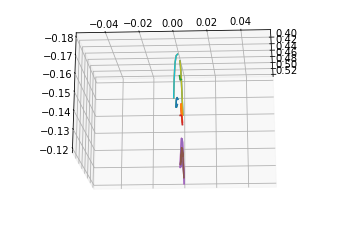

In [40]:
HTML(plot_and_rotate(c_inputs, c_output, frames, 0).to_html5_video())

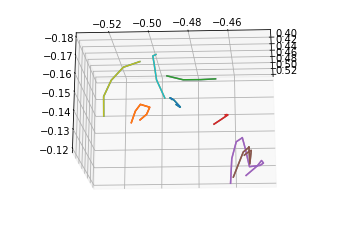

In [41]:
c_inputs = inputs.clone()
HTML(plot_and_rotate(c_inputs, c_labels, frames, 0).to_html5_video())

We repeat the same process for the last test batch.

In [44]:
# Last batches of test -output_test, inputs_test, labels_test-.
frames = [200, 3000]

c_inputs = inputs_test.clone()
c_output = output_test.clone()
c_labels = labels_test.clone()

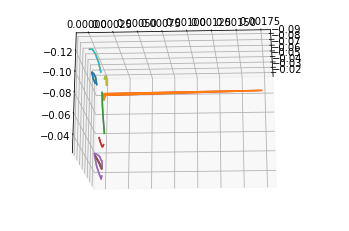

In [45]:
HTML(plot_and_rotate(c_inputs, c_output, frames, 1).to_html5_video())

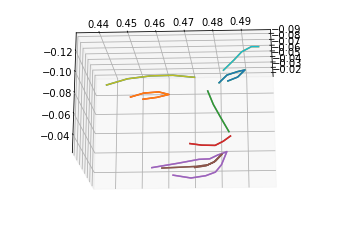

In [46]:
c_inputs = inputs_test.clone()
HTML(plot_and_rotate(c_inputs, c_labels, frames, 1).to_html5_video())

### Slice of frames
Now let's plot a sequence of frames of the selected video. We will plot both the groundtruth and the predicted.

In [51]:
frames = [i for i in range(2000,2010)]
video_n = 6

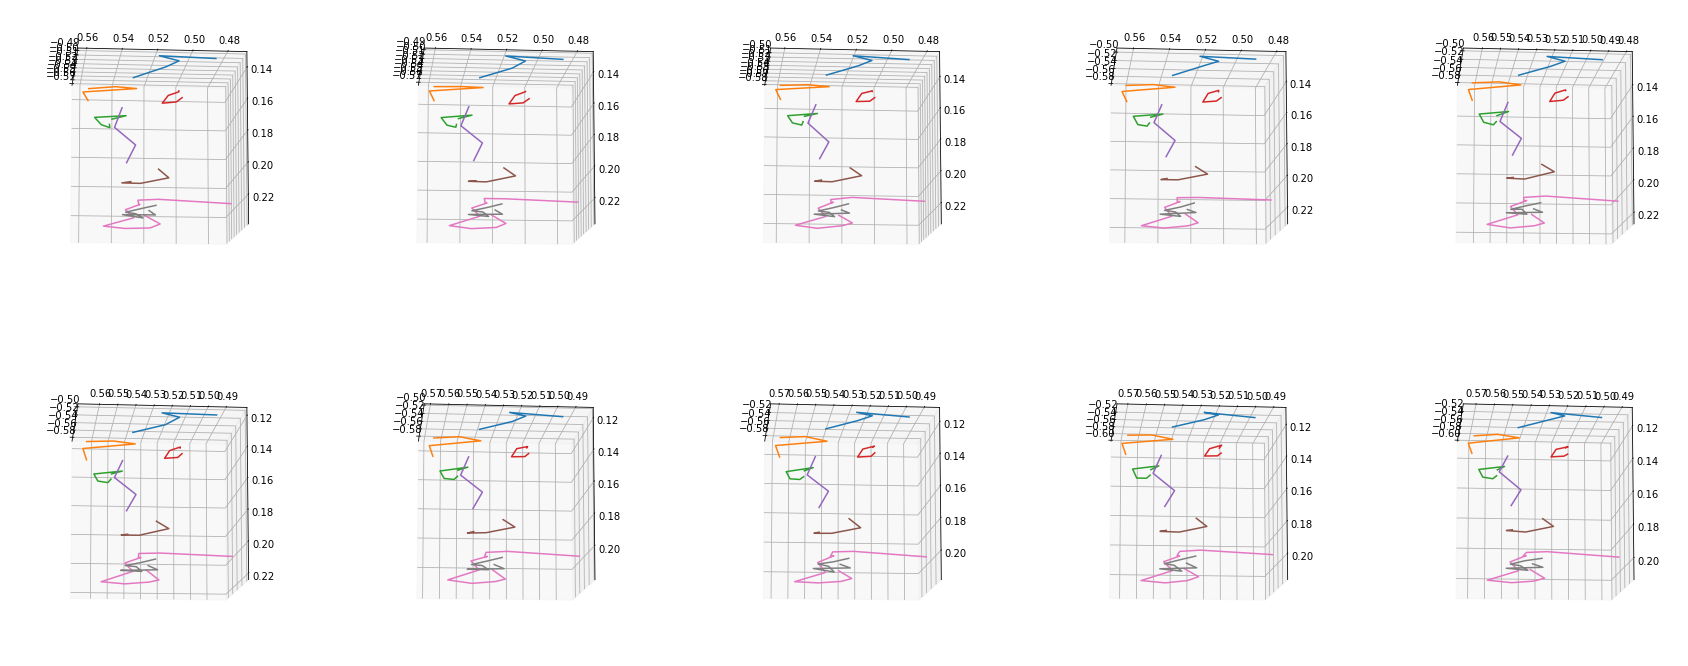

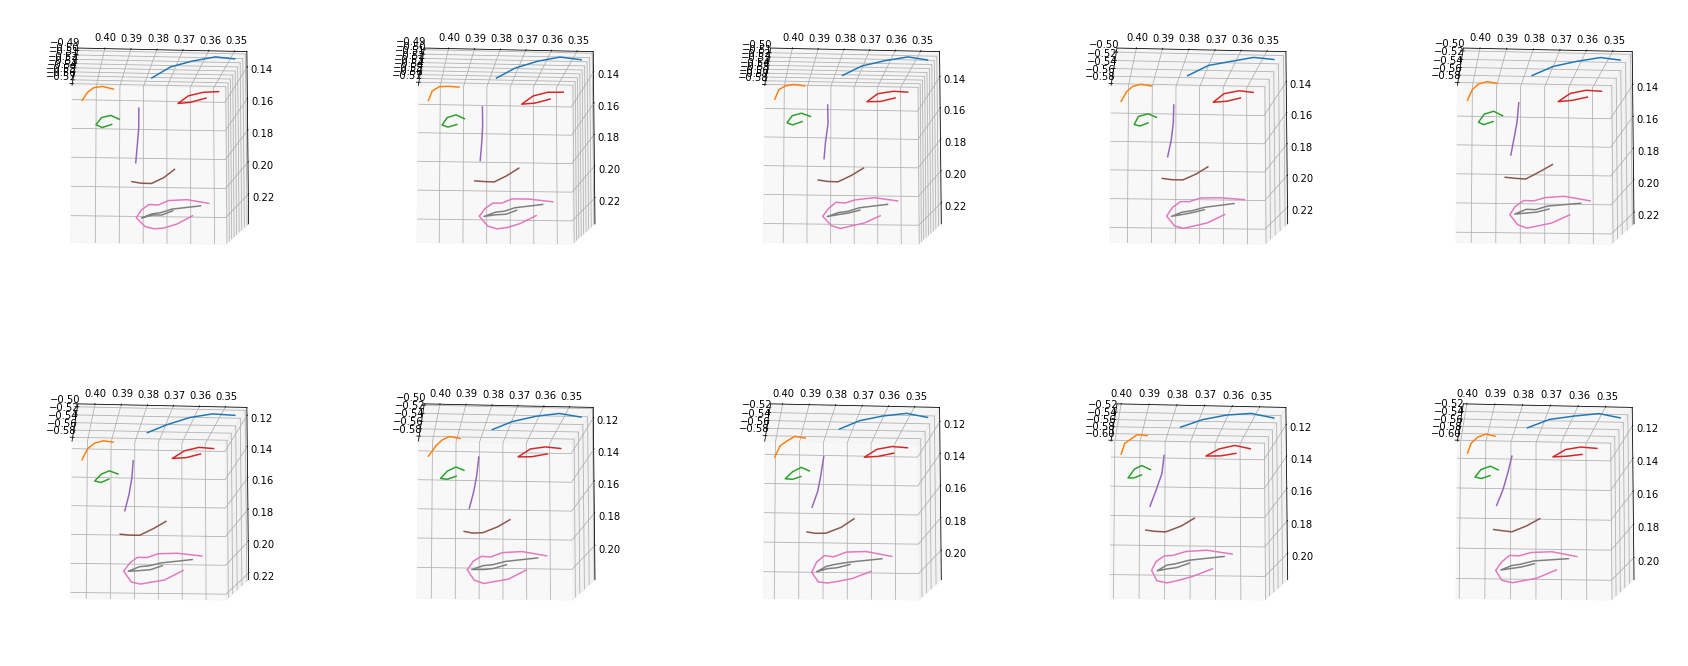

In [52]:
plot_frames(tr_predictions, tr_groundtruth, tr_inputs, video_n, frames)